# Test challenge for retail company

This notebook corresponds to the *"Getting started"* section of the test challenge

This section involves 5 items, as follows:
1. Customer behavior after purchase at showroom
2. Life Time Value by costumer
3. Cohort for customers and materials
4. Cohort for customers and product type
5. Top speed of sale product (1 day window)

## Preprocessing

First of all, we have to do the imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

Then, read the data from the csv file. We will use a pandas Dataframe structure 

In [2]:
df = pd.read_csv('../data/orders_report.csv')

# switch to datetime data type for date columns 
df['Orders Completed Date'] = pd.to_datetime(df['Orders Completed Date'], format='%Y-%m-%d')

# switch to float data type for numeric columns
df['Orders Payment Total'] = [float(s.replace(',','')) for s in df['Orders Payment Total']]

In [3]:
df.dtypes

Orders Completed Date        datetime64[ns]
Orders Email Hash                    object
Orders Number                        object
Variants SKU                         object
Products Name                        object
Line Items Quantity                   int64
Line Items Price                    float64
Material Categories Name             object
Material Groups Name                 object
Orders Payment Total                float64
Orders Currency                      object
Shipping Address ISO Name            object
Purchase Locations Method            object
dtype: object

## 1. Customer behavior after purchase at showroom

The statement for the first item is as follows:


* <cite>
Create a comprehensive way to show when a customer has its first purchase at the showroom (Purchase location == offline, you can see the column in the file I've attached below) and we are interested in knowing what is the behavior on the subsequent purchases (for example if the 2nd transaction happens online, and so on). A chart and a table it would be useful.
</cite>

So, the interpretation is as follows:
1. Identify the first purcharse at showroom
2. Identify the subsequent purchases 

We are going to make use of three columns ['Orders Completed Date', 'Orders Email Hash', 'Purchase Locations Method']

In [4]:
df_behavior = df[['Orders Completed Date', 'Orders Email Hash', 'Purchase Locations Method']].copy()

df_behavior.rename(columns={'Orders Completed Date' : 'orders_completed_date', 
                            'Orders Email Hash': 'orders_email_hash', 
                            'Purchase Locations Method': 'purchase_location_method'}, 
                   inplace=True)

Now we can implement an algorithm that help us to identify subsequent purchase patterns. Let's start.

In [5]:
# Sort values to improve the algorithm
df_behavior.sort_values(['orders_email_hash', 'orders_completed_date', 'purchase_location_method'], inplace=True)

The subsequent purchase pattern is set as the a new column in the dataframe called 'purchase_sequence' where:
* 0 means no subsequence
* 1 means the first purchase at showroom (purchase_location_method == 'offline')
* '>1' means the subsequent number of purchase after first purchase at showroom

In [6]:
## Set the purchase sequence after a first purchase at showroom

# Initialize variables
purchase_sequence = pd.Series(np.zeros(df_behavior.shape[0]), index=df_behavior.index, dtype=np.int)
customer = ''
purcharse_seq_number = 0
 
    
# Iterate of date, email sorted dataframe
for i, p in df_behavior.iterrows():
    
    if p.orders_email_hash == customer:
        
        if purcharse_seq_number > 0:
            purcharse_seq_number += 1
        
        elif p.purchase_location_method == 'offline':
            purcharse_seq_number = 1
        
    else:
        customer = p.orders_email_hash
        
        if p.purchase_location_method == 'offline':
            purcharse_seq_number = 1
        
        else:
            purcharse_seq_number = 0
    
    purchase_sequence[i] = purcharse_seq_number
    
df_behavior['purchase_sequence'] = purchase_sequence

Now lets take a look at the **distribution** of customer purchases with at least two transactions

In [7]:
df_purchase_sequence = df_behavior[df_behavior.purchase_sequence > 1]

In [8]:
df_purchase_sequence.shape

(1224, 4)

In [9]:
df_purchase_sequence.purchase_sequence.describe()

count    1224.000000
mean        2.834150
std         1.368174
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: purchase_sequence, dtype: float64

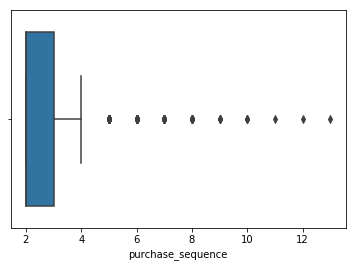

In [10]:
sns.boxplot(df_purchase_sequence.purchase_sequence)

We can also **count** the ocurrences of the purchase sequences

In [11]:
purchase_seq_counts = df_purchase_sequence.groupby(['purchase_sequence', 'purchase_location_method']).count()['orders_email_hash']

df_purchase_seq_counts = pd.DataFrame(purchase_seq_counts) \
    .rename(columns={'orders_email_hash':'quantity'}) \
    .reset_index(level=purchase_seq_counts.index.names)

df_purchase_seq_counts

,purchase_sequence,purchase_location_method,quantity
0,2,offline,615
1,2,online,86
2,3,offline,202
3,3,online,81
4,4,offline,77
5,4,online,45
6,5,offline,33
7,5,online,22
8,6,offline,14
9,6,online,12


Finally, let's make the histogram with the counts of each sequence

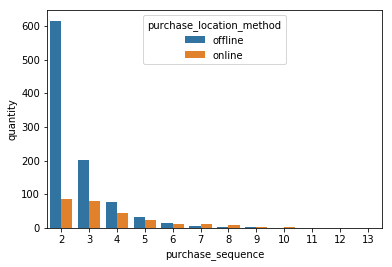

In [12]:
sns.barplot(df_purchase_seq_counts.purchase_sequence, \
            df_purchase_seq_counts.quantity, \
            df_purchase_seq_counts.purchase_location_method,
           )

### Results

* There is a decreasing exponential rate on the offline purchases after the first purchase at showroom.
* 75% (3rd quartile) of sequences reaches the third consecutive purchase (purchases with more than 4 sequences may be asumed as outliers).

### Further analysis


Next step may involve different alternatives, for instance:
* analyse other [behavioral factors](https://en.wikipedia.org/wiki/Consumer_behaviour#Post-purchase_evaluation) of the customers.
* evaluate the prediction of behavioral intentions of the customers. 
* analyse the sequence of purchases from every purchase at showroom (not only the first one).

## 2. Life Time Value by costumer

The statement for the second item is as follows:
* <cite>
We want to know the LTV (lifetime value) by customer
</cite>

Customer Lifetime Value ([CLV](https://en.wikipedia.org/wiki/Customer_lifetime_value)) in its [simplified definition](https://en.wikipedia.org/wiki/Customer_lifetime_value#Methodology), requires the following elements:
* Average (yearly) revenue per customer (ARC)
* Gross margin per customer (GC)
* Monthly churn rate (CR)

We assume GC and CR as constants, since we need aditional data (not present in the challenge dataset) to calculate these variables.

So, the objective is to calculate the CLV based on the ARC, as follows:

**CLV** = (**ARC** * GC) / CR

To calculate ARC, we first have to process our dataset. A proposed preprocessing pipeline is defined as follows:

1. filter dataset to customer, order date, order total payment, order currency.
2. Normalize currencies.
3. Calculate average revenues, by year.
4. Calculate CLV

We start by **1. filtering the dataset**

In [13]:
## Filter dataset to customer, order date, total payment and currency

columns = ['Orders Completed Date', 'Orders Email Hash', \
           'Line Items Quantity', 'Line Items Price',\
           'Orders Currency']

df_revenues = df[columns].copy()

Now, let's **2. normalize currencies**

In [14]:
df_revenues['Orders Currency'].unique()

array(['CAD', 'USD', 'GBP'], dtype=object)

We can suppose these are [ISO Currency Codes](https://www.ibm.com/support/knowledgecenter/en/SSZLC2_7.0.0/com.ibm.commerce.payments.developer.doc/refs/rpylerl2mst97.htm), so  \['CAD', 'USD', 'GBP'\] corresponds to \['Canadian Dollar
', 'US Dollar', 'Pound Sterling'\], respectively.

A naive approximation to currency normalization is to use **current exchange rates**.
In 2018-10-19, current rates are:

In [15]:
current_rates = {'CAD': 0.7628, 'USD': 1.0, 'GBP': 1.3063} # Retrieved from https://markets.ft.com on 2018-10-19

In [16]:
## Normalize currencies to USD
usd_currency = pd.Series(index=df_revenues.index)

for k, v in current_rates.items():
    idx = df_revenues[df_revenues['Orders Currency'] == k].index
    usd_currency.iloc[idx] = df_revenues.iloc[idx]['Line Items Price'] * v * df_revenues.iloc[idx]['Line Items Quantity']
    
df_revenues['line_items_price_total_USD'] = usd_currency

Lets check the data with the new column *orders payment total* in USD

In [17]:
df_revenues.head()

,Orders Completed Date,Orders Email Hash,Line Items Quantity,Line Items Price,Orders Currency,line_items_price_total_USD
0,2018-09-21,b6efaf41cdb44733b926b23222521439,1,495.0,CAD,377.5860
1,2018-09-26,bd9eabcb802d539acd17097a9963cd19,1,62.0,CAD,47.2936
2,2018-09-08,d6bcbdb2f3564726da36c30a96b70cba,1,69.0,USD,69.0000
3,2018-09-11,3468d1e012dc8bd76b95e31ecd975521,1,70.0,CAD,53.3960
4,2018-09-10,95f131c2ffa9a2600df63444daabde32,1,0.0,USD,0.0000


Now, we are ready to calculate **3. average revenues by year**

In [18]:
## Calculate average revenues by year
group_columns = ['Orders Email Hash', 'Orders Completed Date', 'line_items_price_total_USD']

# Group by year
df_revenues_avg = df_revenues[group_columns].groupby([df_revenues['Orders Email Hash'],\
                                                      df_revenues['Orders Completed Date'].dt.year,\
                                                     ]).sum()

df_revenues_avg = pd.DataFrame(df_revenues_avg) \
                    .reset_index(level=df_revenues_avg.index.names)

# Average revenue in years
df_revenues_avg = df_revenues_avg[['Orders Email Hash',
                                   'line_items_price_total_USD']]\
.groupby(['Orders Email Hash'])\
.mean()

In [19]:
df_revenues_avg

,line_items_price_total_USD
Orders Email Hash,
000029a046d343e59391698c4d3ee52b,95.00000
0000bb341d12c611cc83000e2d8cc763,159.00000
00013067c55d8aec8d02388e2bcbaa0d,138.00000
00018d79a812ed1444f83a8b209b55f5,131.00000
000198adcd846d3fc43c05a183784cdf,290.00000
0001c3a9d12bfc680436366b094e69be,125.00000
0003cceee86838c68c1ebf22f708ee04,59.00000
0004496bc615956f017524a7fb80318d,165.00000
0004954cb4ce00aeefca6329c1bc4ee1,171.63000


Finally, in order to **4. calculate the CLV**, we define constants for CR and GC.  

In [20]:
## calculate Customer Lifetime Value

# Initialize values with supposed constants
CR = 0.1
GC = 0.5

clv_years = (df_revenues_avg * GC) / CR
clv_years.rename(columns={'line_items_price_total_USD': 'clv_usd'}, inplace=True)

Now, we can print a preview of CLV

In [21]:
clv_years.sort_values(['clv_usd'], ascending=False, inplace=True)

In [22]:
clv_years.head(10)

,clv_usd
Orders Email Hash,
b70db9264ce0b0168dbf1a641ca2c7fd,44600.000000
686c37c9eb13a854e4f66f153ab4072c,25810.000000
0894cad914d2386cec8b164fbfde9076,25645.000000
1fe6ef810792f5f215948eae99457603,24436.298000
88350c0d1b30df0ce565e72fd5cd860d,23910.000000
2babc97dc37580a6ef0474ba388baf32,23085.000000
9888f77da78c71e6f23390d7c0c7916f,22719.998000
72414671481d220dfcb856457129b2f0,21805.000000
218f052ca6ae2d95157e73b89bd98f2c,21021.666667


The distribution for the CLV is as follows:

/home/zamu/.virtualenvs/mejuri/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


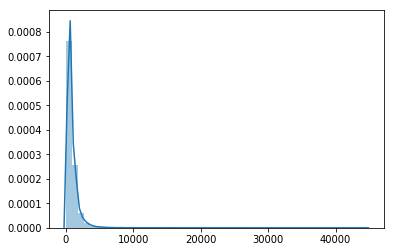

In [23]:
sns.distplot(clv_years)

In [24]:
clv_years.describe()

,clv_usd
count,85282.000000
mean,879.807401
std,911.564196
min,0.000000
25%,347.074000
50%,650.000000
75%,1075.000000
max,44600.000000


### Results 

At glance, the data shows a [skewed right (positive)](https://en.wikipedia.org/wiki/Skewness) distribution.  

Filtering data to CLV greater than 10000, we observed a possible **segmentation** in CLV lower than 20000, between 20000 and 30000, and greater than 30000. 

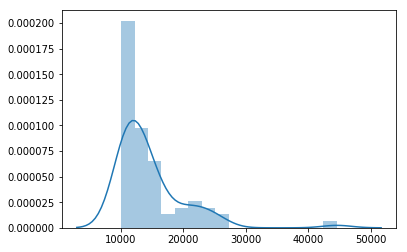

In [25]:
sns.distplot(clv_years[clv_years['clv_usd'] > 10000])

### Further analysis

* Use daily exchange rates to get more accurate values
* Apply [clustering](https://en.wikipedia.org/wiki/Cluster_analysis) techniques for customer segmentation
* Use additional data required for claculate CLV (such as [Gross Contribution Margin](https://en.wikipedia.org/wiki/Contribution_margin) and [Churn rate](https://en.wikipedia.org/wiki/Churn_rate))
* Evaluate machine learning models for [churn prediction](https://www.kaggle.com/mainakdatageek/churn-prediction-machine-learning-starter)

## 3. Cohort for customers and materials

The statement is as follows:

<cite>
* We want to create a cohort to know the customers who first purchased a certain material (there's a column called material group name) and so on. For example:

|                 | Q1      | Q2    | Q3    | Q4    |
|-----------------|---------|-------|----------------
| bought Gold     | 5000    | 1000  | 500   | 50    |
| bought Vermeil  | 5000    | 1000  | 500   | 50    |

Note: for instance, in the first row, 5000 (Q1) means 5000 customers bought gold in the first quarter, and 1000 (Q2) only 1000 bought again on the Q2, etc. 
</cite>

Firts, we have to preprocess data in column *Material Categories Name*

### Preprocessing

Let's split material catergories names and generate a list of unique materials 

In [26]:
material_categories = [s.strip() for x in df['Material Categories Name'].unique() for s in str(x).split(',')]

df_material_categories = pd.Series(material_categories).unique()

In [27]:
df_material_categories

array(['Solid Yellow Gold', 'Diamond', 'Gold Vermeil', 'White Sapphire',
       'Sterling Silver', 'nan', 'Solid White Gold', 'London Blue Topaz',
       'Pearl', 'Solid Rose Gold', 'White Topaz', 'Black Diamond',
       'Emerald', 'Turquoise', 'Rose Quartz', 'Black Onyx',
       'Blue Sapphire', 'Black Spinel', 'Opal', 'Green Topaz',
       'White Evil Eye', 'Citrine', 'Green Amethyst', 'Moonstone',
       'Smokey Quartz', 'Solid Gold', 'Aquamarine', 'Peridot', 'Ruby',
       'Blue Evil Eye', 'Amethyst', 'Garnet', 'Black Pearl', 'Blue Topaz',
       'Smoky Quartz'], dtype=object)

Our aim is to count customers who bought these materials.

In [28]:
columns_materials = ['Orders Completed Date', 'Orders Email Hash', 'Material Categories Name']

df_materials = df[columns_materials].copy()

First, we have to process 'Material Categories Name' in order to get individual records for each material. 
For instance:

* Date, Email, Materials

to:
* Date, Email, Material_1
* Date, Email, Material_2
* ...
* Date, Email, Material_n

In [29]:
## Move materials catergories to rows 
df_material_categories = df_materials['Material Categories Name'].str.split(',', expand=True)

df_material_categories = pd.concat([df_materials, df_material_categories], axis=1)

df_material_categories = pd.melt(df_material_categories, \
                                 id_vars=['Orders Completed Date','Orders Email Hash','Material Categories Name'],\
                                 var_name='material_position',\
                                 value_name='material')

df_material_categories = df_material_categories.drop(['Material Categories Name', 'material_position'], axis=1)

df_material_categories = df_material_categories[df_material_categories['material'].notna()]

In [30]:
df_material_categories

,Orders Completed Date,Orders Email Hash,material
0,2018-09-21,b6efaf41cdb44733b926b23222521439,Solid Yellow Gold
1,2018-09-26,bd9eabcb802d539acd17097a9963cd19,Solid Yellow Gold
2,2018-09-08,d6bcbdb2f3564726da36c30a96b70cba,Gold Vermeil
3,2018-09-11,3468d1e012dc8bd76b95e31ecd975521,Sterling Silver
5,2018-09-14,0697059166921e625cec5d031fc9fecc,Gold Vermeil
6,2018-09-14,0697059166921e625cec5d031fc9fecc,Gold Vermeil
7,2018-09-21,dd50c652fe716a44be2ccb024de8ab76,Gold Vermeil
8,2018-09-13,ed4bce97bedb3a8c5573a2fe9327a685,Solid White Gold
9,2018-09-13,ed4bce97bedb3a8c5573a2fe9327a685,Solid White Gold
10,2018-09-30,3f6936bb5515186ec74c71baf105447f,Solid Yellow Gold


Now, we can **count** how many customers bought materials

In [31]:
df_material_boughts = df_material_categories.groupby( \
    [df_material_categories['material'],
     df_material_categories['Orders Completed Date'].dt.year, 
     df_material_categories['Orders Completed Date'].dt.quarter]).count()

df_material_boughts.rename(columns={'Orders Completed Date': 'quantity'}, inplace=True)

In [32]:
df_material_boughts

quantity  \
material          Orders Completed Date Orders Completed Date             
 Amethyst         2018                  2                            13   
                                        3                             9   
 Aquamarine       2018                  2                            25   
                                        3                            24   
                                        4                             1   
 Black Diamond    2016                  2                            40   
                                        3                            60   
                                        4                           163   
                  2017                  1                           145   
                                        2                           153   
                                        3                           254   
                                        4                           517   
                  2018                  1                           337   
                                        2                           300   
                                        3                           421   
                                        4                            23   
 Black Onyx       2018                  2                           116   
                                        3                           156   
                                        4                             9   
 Black Pearl      2016                  2                             5   
                                        3                            12   
                                        4                            57   
                  2017                  1                            44   
                                        2                            32   
                                        3                            38   
                                        4                            92   
                  2018                  1                            45   
                                        2                            32   
 Black Spinel     2016                  4                            24   
                  2017                  1                            30   
...                                                                 ...   
Solid White Gold  2017                  3                           452   
                                        4                          1434   
                  2018                  1                          1085   
                                        2                          1191   
                                        3                          1602   
                                        4                           147   
Solid Yellow Gold 2016                  1                           149   
                                        2                           620   
                                        3                           910   
                                        4                          1708   
                  2017                  1                          1902   
                                        2                          2612   
                                        3                          4415   
                                        4                         10558   
                  2018                  1                          9111   
                                        2                         13636   
                                        3                         20817   
                                        4                          1126   
Sterling Silver   2016                  1                           236   
                                        2                           272   
                                        3                           294   
             

Now, let's get some useful data about dates, and drop duplicates

In [33]:
df_material_categories['order_year'] = df_material_categories['Orders Completed Date'].dt.year
df_material_categories['order_quarter'] = df_material_categories['Orders Completed Date'].dt.quarter

df_material_categories.drop(['Orders Completed Date'], axis=1, inplace=True)

df_material_categories.drop_duplicates(inplace=True)

In [34]:
df_material_categories

,Orders Email Hash,material,order_year,order_quarter
0,b6efaf41cdb44733b926b23222521439,Solid Yellow Gold,2018,3
1,bd9eabcb802d539acd17097a9963cd19,Solid Yellow Gold,2018,3
2,d6bcbdb2f3564726da36c30a96b70cba,Gold Vermeil,2018,3
3,3468d1e012dc8bd76b95e31ecd975521,Sterling Silver,2018,3
5,0697059166921e625cec5d031fc9fecc,Gold Vermeil,2018,3
7,dd50c652fe716a44be2ccb024de8ab76,Gold Vermeil,2018,3
8,ed4bce97bedb3a8c5573a2fe9327a685,Solid White Gold,2018,3
10,3f6936bb5515186ec74c71baf105447f,Solid Yellow Gold,2018,3
12,87b083bb0b094c61bcba281fd508ae09,Sterling Silver,2018,3
13,91a4540e5723713cc0cddb1deb809ba7,Gold Vermeil,2018,4


Alright, now we have data ready to count customers and their recurrent behaviour in buying a given material.

### Cohort

For a given year and for quarters Q1 to Q4, we must:

1. Count the number of clients who bought a given material in Q
2. Count the number of clients who bought the same material in next quarter (Q +1)

First, we should sort our data to improve performance

In [35]:
df_material_categories = df_material_categories.sort_values(['order_year',\
                                                             'material',\
                                                             'Orders Email Hash',\
                                                             'order_quarter'])

df_material_categories = pd.concat([df_material_categories, df_material_categories['order_quarter'].astype(str).str.get_dummies()], axis=1)

Generate [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) for processing counts by row

In [36]:
df_material_categories_quarter_dummies = df_material_categories.drop(['order_quarter'], axis=1).drop_duplicates()

df_material_categories_quarter_dummies = df_material_categories_quarter_dummies.groupby([df_material_categories_quarter_dummies['Orders Email Hash'],\
                                                                                         df_material_categories_quarter_dummies['material'],\
                                                                                         df_material_categories_quarter_dummies['order_year'],\
                                                                                        ]).sum()

df_material_categories_quarter_dummies.reset_index(level=['Orders Email Hash',\
                                                          'material',\
                                                          'order_year'], inplace=True)

df_material_categories_quarter_dummies.sort_values(['order_year', 'material', 'Orders Email Hash'], inplace=True)

In [37]:
df_material_categories_quarter_dummies

,Orders Email Hash,material,order_year,1,2,3,4
1133,01d6fceff48b51ea45c5a9a18156528a,Black Diamond,2016,0,0,0,1
1265,020376425aa0c9ed3a826cf395aae3f2,Black Diamond,2016,0,0,0,1
1349,02189b2da0e7ecc863d4da6a2324dcef,Black Diamond,2016,0,0,1,0
2563,0401c2c69b583bacff01f1f068faf0b9,Black Diamond,2016,0,0,0,1
3337,052f8777c7d4f3d1875658008f6e641f,Black Diamond,2016,0,1,0,0
4962,07bdd7763c28c02f60e295c0370bd455,Black Diamond,2016,0,1,0,0
5496,08b33d5833b92ca7c166887427ae5ed8,Black Diamond,2016,0,1,0,0
5647,08f4dcb3e72f24f624c2e01e3d265908,Black Diamond,2016,0,0,1,0
6320,0a1b984c080818b0d8c49bf2a5cd783d,Black Diamond,2016,0,0,0,1
6353,0a290b808796322599b01d4b6a730fb0,Black Diamond,2016,0,0,1,0


Now, lets generate our cohort by counting customers (email), who bought same materials from Q1 to Q4

Some considerations:
* Only consecutive buys are considered. ie. A customer who bought a material on Q1 and Q2 is counted. A customer who bought a material on Q1 and Q3, but not on Q2 isn't counted.

In [38]:
## Count coustomers who bought same materials 
result = []

for row in df_material_categories_quarter_dummies.iterrows():
    counts = [0,0,0,0] # Result counts for Q1 to Q4

    for i in range(4):
        #print(row[1][str(i+1)])
        if row[1][str(i+1)] > 0:
            counts[i] += 1
        else:
            break
    
    aux = []
    aux.append(row[1]['order_year'])
    aux.append(row[1]['material'])
    for x in counts:
        aux.append(x)
        
    result.append(aux)

In [39]:
df_material_categories_sum = pd.DataFrame(result, columns=['order_year', 'material', 'Q1', 'Q2', 'Q3', 'Q4'])

df_material_categories_sum = df_material_categories_sum.groupby([df_material_categories_sum['order_year'], df_material_categories_sum['material']]).sum()

df_material_categories_sum = df_material_categories_sum[df_material_categories_sum['Q1'] > 0]

#df_material_categories_sum.reset_index(level=['order_year', 'material'], inplace=True)

### Results

Next, we show the number of customers who bought materials in consecutive quarters from 2016 to 2018

In [40]:
df_material_categories_sum

Q1   Q2   Q3  Q4
order_year material                             
2016        Blue Evil Eye      210    1    0   0
            White Evil Eye     129    2    0   0
            White Sapphire      40    2    0   0
           Gold Vermeil         59    2    0   0
           Solid Yellow Gold   142    8    1   0
           Sterling Silver     220    3    1   0
2017        Black Diamond      136    6    0   0
            Black Pearl         41    1    0   0
            Black Spinel        29    0    0   0
            Blue Evil Eye      119    2    0   0
            Blue Sapphire       14    0    0   0
            Blue Topaz          22    0    0   0
            Citrine             26    0    0   0
            Diamond            446   10    0   0
            Emerald             18    0    0   0
            Opal                37    1    0   0
            Pearl               56    3    0   0
            Ruby                21    1    0   0
            Smoky Quartz        13    0    0   0
            White Evil Eye     190    6    0   0
            White Sapphire     556   29    5   1
           Gold Vermeil        784   43   13   4
           Solid Rose Gold     241    8    1   0
           Solid White Gold    191    8    1   1
           Solid Yellow Gold  1303  120   23  11
           Sterling Silver     332   24    2   0
2018        Black Diamond      304   10    0   0
            Black Pearl         45    0    0   0
            Blue Evil Eye       28    0    0   0
            Blue Sapphire       63    2    1   0
            Blue Topaz          11    0    0   0
            Diamond           1574   87   10   0
            Emerald              8    0    0   0
            Green Topaz         90    1    0   0
            Moonstone           17    0    0   0
            Opal               129    1    0   0
            Pearl              602   14    1   0
            Ruby                10    0    0   0
            Turquoise            6    1    0   0
            White Evil Eye     175    3    0   0
            White Sapphire    6626  302   35   0
            White Topaz        378   10    1   0
           Gold Vermeil       9332  854  176   7
           Solid Rose Gold     665   36    6   0
           Solid White Gold    830   47    5   0
           Solid Yellow Gold  6123  893  228   7
           Sterling Silver    2793  159    9   0

In [41]:
#sns.heatmap(df_material_categories_sum[)
data = df_material_categories_sum.sort_values(['order_year','Q1', 'Q2', 'Q3', 'Q4'], ascending=False)

#### Visualizations

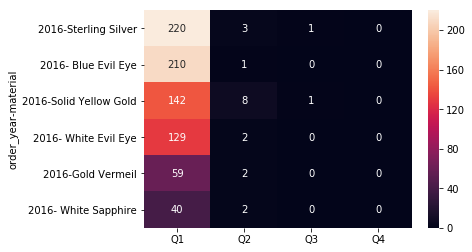

In [42]:
sns.heatmap(data.loc[[2016,]], annot=True, fmt='d')

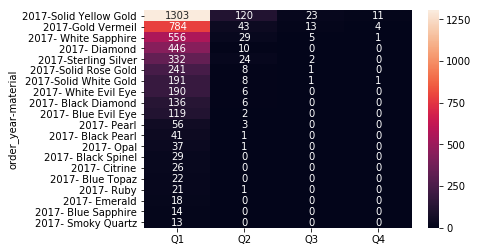

In [43]:
sns.heatmap(data.loc[[2017,]], annot=True, fmt='d')

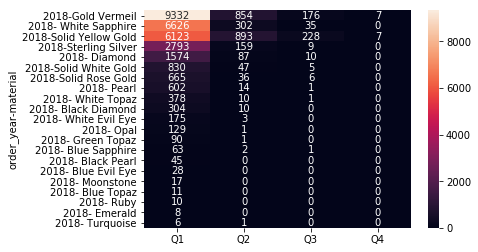

In [44]:
sns.heatmap(data.loc[[2018,]], annot=True, fmt='d')

### Observations

* Top sales in material ranking changed over the period 2016-2018.
* Alternative material had increased in years.

### Further analysis

* Calculate the variance among sales material ranking from year to year to understand tendencies.
* Analyse the movement among selled materials for customer, or segments
* Analyse the factors that make customers to vary over materials or other product categories.

## 4. Cohort for customers and product type

The statement is as follows:

<cite>
* We want to create a cohort to know the customers who first purchased a certain product type and so on. In this case, the data is not clean, you should extract (or fix the data) the type from the product name (the types are Ring, necklace, Stud, bracelet, earrings, hoops), and the cohort should look like.

|                   | Q1      | Q2    | Q3    | Q4    |
| ------------------|---------|-------|----------------
| bought Ring       | 5000    | 1000  | 500   | 50    |
| bought bracelet   | 5000    | 1000  | 500   | 50    |
</cite>

Alright, the first thing to do is to import and clean the data.

### Preprocessing

This step involves:

1. Identify possible categories from product names
2. Classify product names into categories
3. 

#### 1. Identify categories

The strategy is to identify key terms from *products name* using a bag of words approach

In [45]:
df_product_names = df[['Orders Completed Date', 'Orders Email Hash', 'Products Name']].copy()

In [46]:
product_names = df_product_names['Products Name'].sort_values().unique()

In [47]:
product_name_terms = [t.lower() for l in [x.split(' ') for x in product_names] for t in l]

product_name_terms = pd.Series(product_name_terms).sort_values().unique()


There is a manual filtering process from the tokenized product_name_terms which results in an exper defined list of keywords defined as product_name_categories

Next, let's generate a dictionary to map **product names** to **product categories**

In [48]:
## Map unique product names to product categories

result = {}

# Expert defined categories through product name analysis
product_name_categories = ['angles', 'anklet', 'bangle', 'blaze', 'bracelet', 'bracelet.',\
                           'case', 'chain', 'chains', 'choker', 'circlet', 'crawlers',\
                           'cuff', 'cuffs', 'earring', 'earrings', 'hoop', 'hoops', 'jackets',\
                           'necklace', 'pendant', 'pin','ring', 'rings', 'sphere', 'stacker',\
                           'spheres', 'stud', 'stud*', 'studs', 'v-ring','wings', 'y-necklace',
                          'signet', 'huggie', 'charm', 'threaders', 'threader', 'gift', 'backing']

## Preprocessing pipeline
# Lowercase
product_names_preprocessed = pd.Series(product_names).str.lower()

# Find a product category keyword in the product name
for t in product_names_preprocessed:
    category = None
    
    for n in product_name_categories:
        if n in t.split(' '):
            category = n
            break
    
    result[t] = category

# Store product category in a new column called product_category
product_category = []

for _, r in df['Products Name'].str.lower().items():
    product_category.append(result[r])

df_product_names['product_category'] = pd.Series(product_category)

The aim is to have every row with some product_category assigned (!= None).

In [49]:
# Every row should have a product caterogy != None
df_product_names[df_product_names['product_category'].isnull()]

,Orders Completed Date,Orders Email Hash,Products Name,product_category


Now, let's clean our data in product_category

In [50]:
to_replace_pattern = '^\w\-|\.|\*|s$'

df_product_names['product_category'] = df_product_names['product_category'].str.replace(to_replace_pattern, '')

In [51]:
df_product_names['product_category'].sort_values().unique()


array(['angle', 'anklet', 'backing', 'bangle', 'blaze', 'bracelet',
       'case', 'chain', 'charm', 'choker', 'circlet', 'crawler', 'cuff',
       'earring', 'gift', 'hoop', 'huggie', 'jacket', 'necklace',
       'pendant', 'pin', 'ring', 'signet', 'sphere', 'stacker', 'stud',
       'threader'], dtype=object)

So, we have a nice (though barely ad-hoc) list of product names classified in product categories. 

Just like for the cohort on materials, we can **count** how many customers bought product categories

In [52]:
df_product_names_backup = df_product_names.copy()

df_product_names = df_product_names.drop(['Products Name'], axis=1)

In [53]:
df_product_name_boughts = df_product_names.groupby( \
    [df_product_names['product_category'],
     df_product_names['Orders Completed Date'].dt.year, 
     df_product_names['Orders Completed Date'].dt.quarter]).count()

df_product_name_boughts.rename(columns={'Orders Completed Date': 'quantity'}, inplace=True)

df_product_name_boughts.drop('Orders Email Hash', axis=1, inplace=True)

df_product_name_boughts.index.rename(['product_category', 'order_year', 'order_quarter'], inplace=True)

In [54]:
df_product_name_boughts

quantity
product_category order_year order_quarter          
angle            2016       1                     9
                            2                     6
anklet           2016       1                     6
                            2                     4
                            3                     2
backing          2018       3                     7
                            4                     1
bangle           2016       1                     3
                            2                     2
                            3                     2
                            4                     1
blaze            2016       3                    16
                            4                    38
                 2017       1                    66
                            2                    53
                            3                    39
bracelet         2016       1                    76
                            2                   133
                            3                    97
                            4                   537
                 2017       1                   314
                            2                   301
                            3                   508
                            4                  1098
                 2018       1                   732
                            2                  1223
                            3                  1886
                            4                    78
case             2018       3                   266
                            4                    13
...                                             ...
sphere           2017       3                   382
                            4                   693
                 2018       1                   536
                            2                   743
                            3                  1245
                            4                    68
stacker          2017       4                  1316
                 2018       1                  1957
                            2                  1021
                            3                  1143
                            4                    70
stud             2016       1                    15
                            2                    51
                            3                   132
                            4                   373
                 2017       1                   450
                            2                   778
                            3                  1299
                            4                  2571
                 2018       1                  1723
                            2                  2109
                            3                  3615
                            4                   237
threader         2017       2                    38
                            3                    51
                            4                   472
                 2018       1                   123
                            2                   145
                            3                   160
                            4                    10

[204 rows x 1 columns]

Now, let's get some useful data about dates, and drop duplicates

In [55]:
df_product_names['order_year'] = df_product_names['Orders Completed Date'].dt.year
df_product_names['order_quarter'] = df_product_names['Orders Completed Date'].dt.quarter

df_product_names.drop(['Orders Completed Date'], axis=1, inplace=True)

df_product_names.drop_duplicates(inplace=True)

In [56]:
df_product_names

,Orders Email Hash,product_category,order_year,order_quarter
0,b6efaf41cdb44733b926b23222521439,ring,2018,3
1,bd9eabcb802d539acd17097a9963cd19,hoop,2018,3
2,d6bcbdb2f3564726da36c30a96b70cba,ring,2018,3
3,3468d1e012dc8bd76b95e31ecd975521,choker,2018,3
4,95f131c2ffa9a2600df63444daabde32,ring,2018,3
5,0697059166921e625cec5d031fc9fecc,hoop,2018,3
6,0697059166921e625cec5d031fc9fecc,necklace,2018,3
7,dd50c652fe716a44be2ccb024de8ab76,stacker,2018,3
8,ed4bce97bedb3a8c5573a2fe9327a685,ring,2018,3
10,3f6936bb5515186ec74c71baf105447f,ring,2018,3


Alright, now we have data ready to count customers and their recurrent behaviour in buying a given material.

### Cohort

For a given year and for quarters Q1 to Q4, we must:

1. Count the number of clients who bought a given product category in Q
2. Count the number of clients who bought the same product category in next quarter (Q +1)

First, we should sort our data to improve performance

In [57]:
df_product_names = df_product_names.sort_values(['order_year',\
                                                             'product_category',\
                                                             'Orders Email Hash',\
                                                             'order_quarter'])

df_product_names = pd.concat([df_product_names, df_product_names['order_quarter'].astype(str).str.get_dummies()], axis=1)

Generate [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) for processing counts by row

In [58]:
df_product_names_quarter_dummies = df_product_names.drop(['order_quarter'], axis=1).drop_duplicates()

df_product_names_quarter_dummies = df_product_names_quarter_dummies.groupby([df_product_names_quarter_dummies['Orders Email Hash'],\
                                                                                         df_product_names_quarter_dummies['product_category'],\
                                                                                         df_product_names_quarter_dummies['order_year'],\
                                                                                        ]).sum()

df_product_names_quarter_dummies.reset_index(level=['Orders Email Hash',\
                                                          'product_category',\
                                                          'order_year'], inplace=True)

df_product_names_quarter_dummies.sort_values(['order_year', 'product_category', 'Orders Email Hash'], inplace=True)

In [59]:
df_product_names_quarter_dummies

,Orders Email Hash,product_category,order_year,1,2,3,4
14906,1aa34ea4f760a1dd3e2450001b50059f,angle,2016,1,0,0,0
22002,274668cc0e3eacd085cada72b1f79f5c,angle,2016,1,0,0,0
37384,430974a66cf58a36e0b8de7f618cbc9e,angle,2016,1,0,0,0
40596,48e1a3e0f8f1f9be5cdca110859de34f,angle,2016,1,0,0,0
40657,48f6c051448b7a15987a62633e6da5f5,angle,2016,0,1,0,0
54662,618cad644ff1dde1c8604543cd3560ea,angle,2016,0,1,0,0
85150,9759b53ef3464f00ceca0ba8d0eef881,angle,2016,1,0,0,0
92889,a4f54c813823bb5280053e25918b0528,angle,2016,0,1,0,0
93709,a65d28eb63b0f550c8843a37c08729ff,angle,2016,0,1,0,0
108931,c15b83fbd8ef0bd9c101fbf2a022d33b,angle,2016,0,1,0,0


Now, lets generate our cohort by counting customers (email), who bought same product_categories from Q1 to Q4

Some considerations:
* Only consecutive buys are considered. ie. A customer who bought a product category on Q1 and Q2 is counted. A customer who bought a product category on Q1 and Q3, but not on Q2 isn't counted.

In [60]:
## Count coustomers who bought same product categories 
result = []

for row in df_product_names_quarter_dummies.iterrows():
    counts = [0,0,0,0] # Result counts for Q1 to Q4

    for i in range(4):
        #print(row[1][str(i+1)])
        if row[1][str(i+1)] > 0:
            counts[i] += 1
        else:
            break
    
    aux = []
    aux.append(row[1]['order_year'])
    aux.append(row[1]['product_category'])
    for x in counts:
        aux.append(x)
        
    result.append(aux)

In [61]:
df_product_names_sum = pd.DataFrame(result, columns=['order_year', 'product_category', 'Q1', 'Q2', 'Q3', 'Q4'])

df_product_names_sum = df_product_names_sum.groupby([df_product_names_sum['order_year'],\
                                                     df_product_names_sum['product_category']]).sum()

df_product_names_sum = df_product_names_sum[df_product_names_sum['Q1'] > 0]

### Results

Next, we show the number of customers who bought materials in consecutive quarters from 2016 to 2018

In [62]:
df_product_names_sum

Q1   Q2  Q3  Q4
order_year product_category                   
2016       angle                8    0   0   0
           anklet               6    0   0   0
           bangle               2    0   0   0
           bracelet            64    1   0   0
           chain              346    9   1   0
           choker              18    1   0   0
           circlet             16    0   0   0
           crawler             39    0   0   0
           cuff                36    1   0   0
           earring            104    1   0   0
           gift                 3    0   0   0
           jacket             123    4   0   0
           necklace           147    4   0   0
           pendant             69    0   0   0
           ring               383   27   7   1
           stud                15    0   0   0
2017       blaze               64    3   0   0
           bracelet           291    6   1   0
           chain              261    6   2   0
           choker             715   22   3   1
           crawler             51    0   0   0
           cuff                93    0   0   0
           earring            228   11   1   0
           gift                14    0   0   0
           hoop                69    2   0   0
           jacket             227    3   0   0
           necklace          1327   33   5   2
           pendant              4    0   0   0
           ring              1471  105  16   5
           sphere             225    4   1   0
           stud               401   17   2   1
2018       bracelet           686   29   3   0
           chain              321   16   4   0
           charm              298   15   3   0
           choker            1640   14   0   0
           cuff              1856   67   6   0
           earring           1385   49   2   0
           gift                62    2   0   0
           hoop              4346  428  52   2
           necklace          4161  178  26   1
           pendant             80    1   0   0
           ring              5369  500  73   0
           signet             613   16   1   0
           sphere             498   16   1   0
           stacker           1444   48   2   0
           stud              1538   79  15   0
           threader           121    1   0   0

In [63]:
#sns.heatmap(df_material_categories_sum[)
data = df_product_names_sum.sort_values(['order_year','Q1', 'Q2', 'Q3', 'Q4'], ascending=False)

#### Visualizations

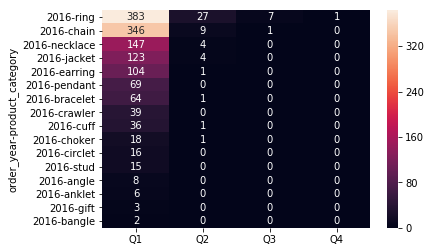

In [64]:
sns.heatmap(data.loc[[2016,]], annot=True, fmt='d')

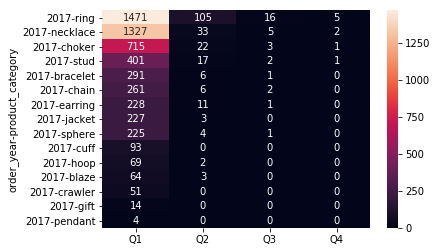

In [65]:
sns.heatmap(data.loc[[2017,]], annot=True, fmt='d')

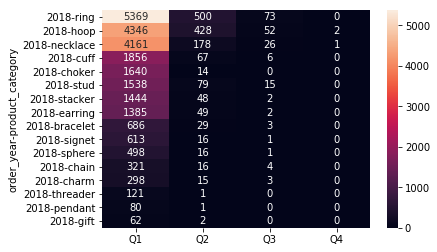

In [66]:
sns.heatmap(data.loc[[2018,]], annot=True, fmt='d')

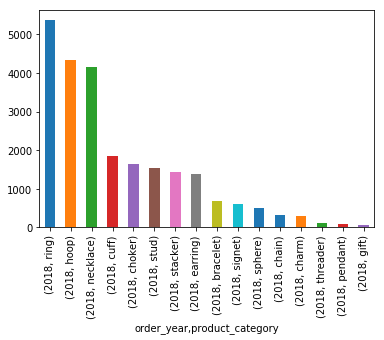

In [67]:
plot_data = data.loc[[2018,]]['Q1']

plot_data.plot.bar()

### Observations

* Top sales in product category ranking changed over the period 2016-2018. In particular, top 3 product categories include ring and necklace, but differ in chain, choker and hoop for 2016, 2017, and 2018 respectively. 
* In 2018.Q1 there is a possible segmentation in the number of custumers and product categories (top 3, 4th to 8th, 9th and beyond)  

### Further analysis

* Calculate the variance among sales product category ranking from year to year to understand tendencies.
* Analyse the movement among selled product categories for customer, or segments.
* Determine [asociation rules](https://en.wikipedia.org/wiki/Association_rule_learning) to understand, for instance, which products are sold together and under which circustances.

## 5. Top speed of sale product (1 day window)

The statement is as follows:
* What product has the highest speed of sale in a 1 day window? and when did it happen?


El speed of sale es la cantidad de productos vendidos por un lapso de tiempo. 
Por ejemplo tenes el product A, tendrias que contar cuantas ventas hubo en un cierto dia. Para ver cual tiene la velocidad de venta mayor, tendrias que ver de todos los productos cual es el que mas se vendio en el lapso de 1 dia.

_Interpretation_:

    Speed of sale: number of products sold in a time window. For instance, the number of sales for a given product (Product A) in a given day (1 day window). The top speed product is the one with higher number of sales for a given day.


First, we choose a particular date (1 day window), then, we can count ocurrencies.

In [110]:
date_for_filtering = '2018-09-21' # For demonstration purposes only

In [68]:
df_product_speed = df[['Orders Completed Date', 'Orders Email Hash', 'Products Name']].copy()

In [111]:
df_product_speed_filtered = df_product_speed[df_product_speed['Orders Completed Date'] == date_for_filtering]\
.groupby(['Products Name'])\
.count()\
.drop('Orders Completed Date', axis=1)\
.rename(columns={'Orders Email Hash': 'quantity'})\
.sort_values('quantity', ascending=False)

In [70]:
df_product_speed_filtered

,quantity
Products Name,
Spiral Earrings,33
Mini Hoop,33
Stacker & Twist Ring Duo,17
Bold Hoops,16
Small Hoops,15
Stacker & Beaded Ring Duo,14
Stacker Ring,13
Editor Hoops,12
Boyfriend Stacker Vermeil,12


### Visualization

Let's take a look to the top 20 products

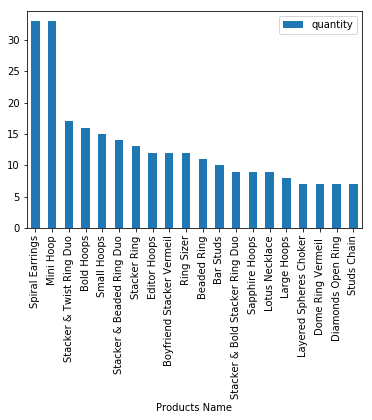

In [71]:
df_product_speed_filtered[:20].plot.bar()

Now, let's do the same count by **product category**

In [106]:
df_product_speed_filtered_category = df_product_names_backup[df_product_names_backup['Orders Completed Date'] == date_for_filtering]\
.groupby([df_product_names_backup['product_category']])\
.count()\
['product_category']\
.rename('quantity')\
.sort_values(ascending=False)

In [107]:
df_product_speed_filtered_category

product_category
ring        193
hoop        133
necklace     78
earring      51
stud         49
bracelet     32
chain        23
cuff         21
stacker      20
sphere       18
choker       16
signet       10
charm         3
case          3
threader      1
gift          1
Name: quantity, dtype: int64

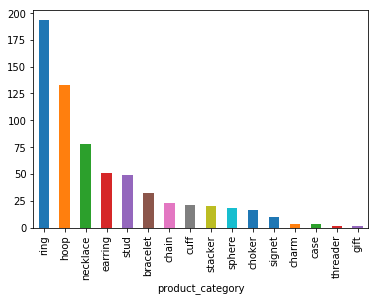

In [108]:
df_product_speed_filtered_category.plot(kind='bar')

### Further analysis

Calculate a speed of sale for products or categories is simple enought for a given point of time. However, the analyst surely would like to have different perspectives of the data. 

A better way to visualize data could be [data cubes](https://en.wikipedia.org/wiki/Data_cube) ([OLAP cubes](https://en.wikipedia.org/wiki/OLAP_cube)) with different dimensions, granularities, and metrics.  This tool could empower non-technical users for data analysis.

Some questions resulting of this analysis:

* What if we measure speed of sales grouped by weeks?
* What if we measure speed of sales for days in the week for a given month or quarter (monday, tuesday, ...)? Is there a day in the week where customers buy more of a product?
* Can we think about speed of sales as a measure of days (or hours) from the release of a promotion campaign to the effective sale of a product?